# Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My Drive/DataHack 4 StockPred

/content/gdrive/My Drive/DataHack 4 StockPred


# Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_colwidth', -1)

import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [ ]:
!pip install pmdarima

In [5]:
import pmdarima as pm

# Reading data

In [6]:
ss = pd.read_csv('SampleSubmission_ZxsCq0O.csv')
train = pd.read_csv('Train_awoL0xl.csv')
test = pd.read_csv('Test_QQKW4dv.csv')

In [7]:
ID_COL, TARGET_COL = 'id', 'Close'

In [8]:
print(f'\nTrain contains {train.shape[0]} samples and {train.shape[1]} variables')
print(f'\nTest contains {test.shape[0]} samples and {test.shape[1]} variables')

features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
print(f'\nThe dataset contains {len(features)} features')


Train contains 73439 samples and 9 variables

Test contains 4223 samples and 5 variables

The dataset contains 8 features


Text(0.5, 1.0, 'Target Distribution')

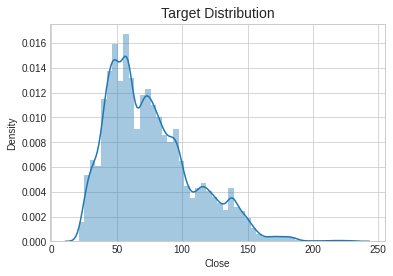

In [9]:
sns.distplot(train[TARGET_COL])
plt.title("Target Distribution", fontsize=14)

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73439 entries, 0 to 73438
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      73439 non-null  object 
 1   stock                   73439 non-null  int64  
 2   Date                    73439 non-null  object 
 3   Open                    73439 non-null  float64
 4   High                    73439 non-null  float64
 5   Low                     73439 non-null  float64
 6   Close                   73439 non-null  float64
 7   holiday                 73439 non-null  int64  
 8   unpredictability_score  73439 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 5.0+ MB


In [24]:
null_values_per_variable = 100 * (train.isnull().sum()/train.shape[0]).round(3)#.reset_index()
null_values_per_variable.sort_values(ascending=False)

dayofweek                 0.0
week                      0.0
day                       0.0
month                     0.0
year                      0.0
unpredictability_score    0.0
holiday                   0.0
Close                     0.0
Low                       0.0
High                      0.0
Open                      0.0
Date                      0.0
stock                     0.0
ID                        0.0
dtype: float64

Text(0.5, 1.0, 'Target Distribution')

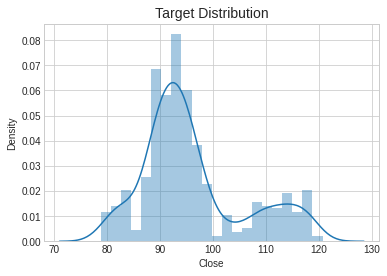

In [25]:
fltr = train['stock'] == 0
sns.distplot(train[fltr][TARGET_COL])
plt.title("Target Distribution", fontsize=14)

Text(0.5, 1.0, 'Target Distribution')

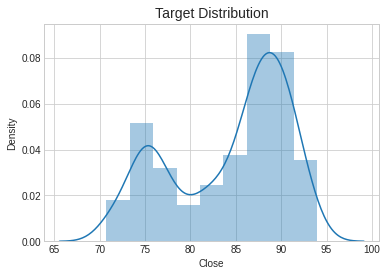

In [26]:
fltr = train['stock'] == 48
sns.distplot(train[fltr][TARGET_COL])
plt.title("Target Distribution", fontsize=14)

# Helper Methods

In [11]:
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
  return mean_squared_error(y_true, y_pred) ** 0.5

In [12]:
def download_preds(preds_test, file_name = 'hacklive_sub.csv'):

  ## 1. Setting the target column with our obtained predictions
  ss[TARGET_COL] = preds_test

  ## 2. Saving our predictions to a csv file

  ss.to_csv(file_name, index = False)

  ## 3. Downloading and submitting the csv file
  from google.colab import files
  files.download(file_name)

# Feature Extraction

In [14]:
df = pd.concat([train, test], axis=0).reset_index(drop = True)

In [15]:
df['Date'] = pd.to_datetime(df["Date"])
for attr in ['year', 'month', 'day', 'week', 'dayofweek']:
  df[attr] = getattr(df['Date'].dt, attr)
train, test = df[:train.shape[0]].reset_index(drop = True), df[train.shape[0]:].reset_index(drop = True)

In [23]:
#Predicting Open High Low for the test data set

In [21]:
df_test = test.copy()

In [ ]:
preds = []
for i in range(train['stock'].nunique()):
  print(f'Iteration : {i}')
  train_stock = train[train['stock'] == i]
  model = pm.auto_arima(np.log(train_stock['Open']), 
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=5,               # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                       
                      max_P=5, max_Q=5, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      scoring='mse')
  pred = model.predict(n_periods = 41)
  preds.extend(pred)


preds = np.exp(preds)
df_test['Open'] = preds

In [ ]:
preds = []
for i in range(train['stock'].nunique()):
  print(f'Iteration : {i}')
  train_stock = train[train['stock'] == i]
  model = pm.auto_arima(np.log(train_stock['High']), 
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=5,               # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                       
                      max_P=5, max_Q=5, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      scoring='mse')
  pred = model.predict(n_periods = 41)
  preds.extend(pred)


preds = np.exp(preds)
df_test['High'] = preds

In [29]:
preds = []
for i in range(train['stock'].nunique()):
  print(f'Iteration : {i}')
  train_stock = train[train['stock'] == i]
  model = pm.auto_arima(np.log(train_stock['Low']), 
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=5,               # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                       
                      max_P=5, max_Q=5, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      scoring='mse')
  pred = model.predict(n_periods = 41)
  preds.extend(pred)


preds = np.exp(preds)
df_test['Low'] = preds

Iteration : 0
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=-4751.805, Time=1.14 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=-4759.586, Time=0.12 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=-4759.105, Time=0.69 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=-4759.350, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=-4759.215, Time=0.06 sec
 ARIMA(0,1,0)(1,0,0)[5] intercept   : AIC=-4759.016, Time=0.85 sec
 ARIMA(0,1,0)(0,0,1)[5] intercept   : AIC=-4759.158, Time=0.30 sec
 ARIMA(0,1,0)(1,0,1)[5] intercept   : AIC=-4757.095, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[5] intercept   : AIC=-4759.806, Time=0.14 sec
 ARIMA(1,1,0)(0,0,1)[5] intercept   : AIC=-4759.206, Time=0.60 sec
 ARIMA(1,1,0)(1,0,1)[5] intercept   : AIC=-4757.146, Time=0.62 sec
 ARIMA(2,1,0)(0,0,0)[5] intercept   : AIC=-4758.320, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[5] intercept   : AIC=-4758.832, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[5] intercept   : AIC=-4759.933, Time=0.16 sec
 ARIM

# Decomposing the series

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [17]:
train_stock0 = train[train['stock'] == 0][['Date','Close']]
train_stock0.index = train_stock0.Date

In [18]:
decomposed_series = seasonal_decompose(train_stock0['Close'], freq=5)

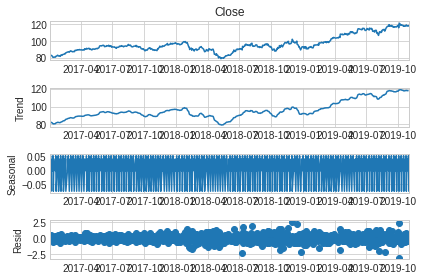

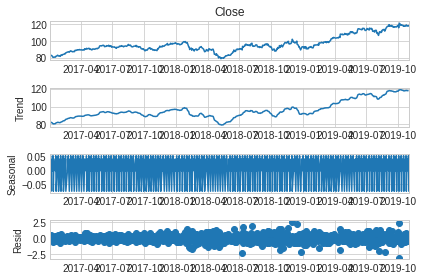

In [19]:
decomposed_series.plot()

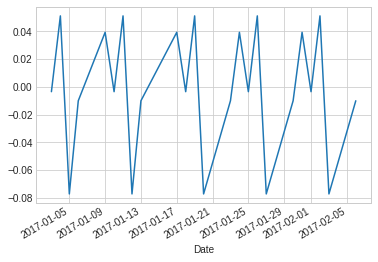

In [20]:
decomposed_series.seasonal[:24].plot()

# Arima

In [ ]:
train['Close_log'] = np.log(train['Close'])
preds = []
for i in range(train['stock'].nunique()):
  print(f'Iteration : {i}')
  train_stock = train[train['stock'] == i]
  model = pm.auto_arima(train_stock['Close_log'], 
                      test='adf',       # use adftest to find optimal 'd'
                      m=1,               # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonaliy 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      scoring='mse')
  pred = model.predict(n_periods = 41)
  preds.extend(pred)


preds = np.exp(preds)



Iteration : 0
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4632.695, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4635.319, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4635.017, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4635.188, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4635.284, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4632.439, Time=0.50 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.868 seconds
Iteration : 1
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6133.531, Time=1.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6128.715, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6136.170, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6135.661, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6126.808, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6134.329, Time=0.21 sec
 ARIM

# Prophet

In [22]:
from fbprophet import Prophet

In [ ]:
preds = []
for i in range(train['stock'].nunique()):
  print(f'Iteration : {i}')
  train_stock = train[train['stock'] == i][['Date','Close','Open','High','Low']]
  train_stock.columns = ['ds','y','Open','High','Low']
  train_stock['y'] = np.log(train_stock['y'])
  train_stock['Open'] = np.log(train_stock['Open'])
  train_stock['High'] = np.log(train_stock['High'])
  train_stock['Low'] = np.log(train_stock['Low'])
  holiday = train[train['stock'] == i and ][['Date', 'holiday']]
  
  m = Prophet()
  m.add_regressor('High')
  m.add_regressor('Low')
  m.add_regressor('Open')
  m.fit(train_stock)

  
  future = m.make_future_dataframe(periods=41, freq='B')
  future['Open'] = np.log(pd.concat([(train[train['stock']==i]['Open']),(df_test[df_test['stock']==i]['Open'])],axis=0).reset_index()['Open'])
  future['High'] = np.log(pd.concat([(train[train['stock']==i]['High']),(df_test[df_test['stock']==i]['High'])],axis=0).reset_index()['High'])
  future['Low'] = np.log(pd.concat([(train[train['stock']==i]['Low']),(df_test[df_test['stock']==i]['Low'])],axis=0).reset_index()['Low'])
  forecast = m.predict(future)

  pred = list(forecast['yhat'][-41:])
  preds.extend(pred)

preds = np.exp(preds)
download_preds(preds,'prophet_stockwise_regressor_log.csv')